## Scraping Wikipedia

Many elements of this code is taken from [this github repo](https://github.com/abetlen/star-chart-notebook/blob/master/Dataset.ipynb) from user abetlen whos goal was to create starmaps, same as our project. However, the code has since been depreciated, and now updated by us below.

In [102]:

import requests
from bs4 import BeautifulSoup
import csv
import webbrowser

wiki = 'https://en.wikipedia.org/wiki/Lists_of_stars_by_constellation'

page = requests.get(wiki).text
soup = BeautifulSoup(page, 'lxml')

# Creating a CSV file named 'star_data.csv'
star_data_csv = open('star_data.csv', 'w', newline = '', encoding = 'utf8')
csv_writer = csv.writer(star_data_csv)
csv_writer.writerow(['name', 'right_ascension', 'declination', 'apparent_magnitude', 'distance (ly)', 'link', 'parent_constellation'])

constellations = []

# Iteratingg through the list of constellations in the Wikipedia page
for constellation in soup.table.find_all('a'):
    page = requests.get('https://en.wikipedia.org' + constellation['href']).text
    starsoup = BeautifulSoup(page, 'html.parser')
    # Creating a list of the column headers because not all constellations have the same headers, we need to index them
    # in order to get our data to fall into the right place in our CSV file
    rows = starsoup.table('tr')[0](title=True)    
    titles = list(x['title'].lower() for x in starsoup.table('tr')[0](title=True))
    table_results = starsoup.table('tr')
    try:
        check = starsoup.table('tr')[0].td['class'][0]
    except:
        check = None
        
    if check == 'mbox-image':
        table = starsoup.find_all('table')[1]
        rows = table.find_all('tr')
        table_results = rows
        titles = list(x['title'].lower() for x in rows[0](title=True))
    
    
    # Some constellations don't have what we need, with the titles listed below
    # The try-except block catches those cases
    
    try:
        namecol = 0
        racol = titles.index('right ascension')
        deccol = titles.index('declination')
        amcol = titles.index('apparent magnitude')
        distcol = titles.index('stellar distance')
    except ValueError:
        continue
    
    # Iterating through each star in the table.
    # Starting at 1 and ending at 4th to last because they are not star data
    
    for star in table_results[1:-3]:
        # An indexible object that allows us to find specifically name, ra, dec, and am columns.
        row = star('td')

        # Checking if the star has a name or not.
        try:
            link = star.a['href']
        
        # If not, they are stored as an empty string
        except (TypeError, KeyError):
            link = ''
        
        try:
            name = row[namecol].a['title']
        except:
            name = "Unnamed Star"
            
        # Finding all of our useful data and storting them as strings
        right_ascension = row[racol].text
        
        declination = row[deccol].text
        apparent_magnitude = row[amcol].text
        parent_constellation = constellation.string
        dist = row[distcol].text
        # Writing our data to a csv
        csv_writer.writerow([name, right_ascension, declination, apparent_magnitude, dist, link, parent_constellation])
    
star_data_csv.close()

## Data Cleaning

In [103]:
import pandas as pd

stars = pd.read_csv('star_data.csv')

In [104]:
# For some reason, wikipedia uses weird unicode characters, replace them with stuff actually on the keyboard
# Also replacing some stuff to get rid of non integer values
stars['apparent_magnitude'] = stars['apparent_magnitude'].str.replace('−', '-')
stars['apparent_magnitude'] = stars['apparent_magnitude'].str.replace('~', '')
stars['apparent_magnitude'] = stars['apparent_magnitude'].str.replace('n/a', '')

stars['declination'] = stars['declination'].str.replace('−', '-')

# This line uses regex to filter out all non-numerical values, while also preserving the decimal
# More info on the .extract() method can be found here: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.extract.html
# More info on regex can be found here: https://docs.python.org/3/howto/regex.html
stars['apparent_magnitude'] = stars['apparent_magnitude'].str.extract('([-+]?\d*\.\d+|\d+)', expand=False)

# Using the .astype() method to turn all values in our column from a string to a float.
stars['apparent_magnitude'] = stars['apparent_magnitude'].astype(float)


stars = stars.loc[stars['apparent_magnitude'] < 8]

# Saving our cleaned df to a csv

stars.to_csv('star_data_clean.csv')

cleanedstars = pd.read_csv('star_data_clean.csv')

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ricky\AppData\Local\Temp\ipykernel_2332\16522672.py:12: SyntaxWarning: invalid escape sequence '\d'
  stars['apparent_magnitude'] = stars['apparent_magnitude'].str.extract('([-+]?\d*\.\d+|\d+)', expand=False)


### Testing

40.7127281 -74.0060152


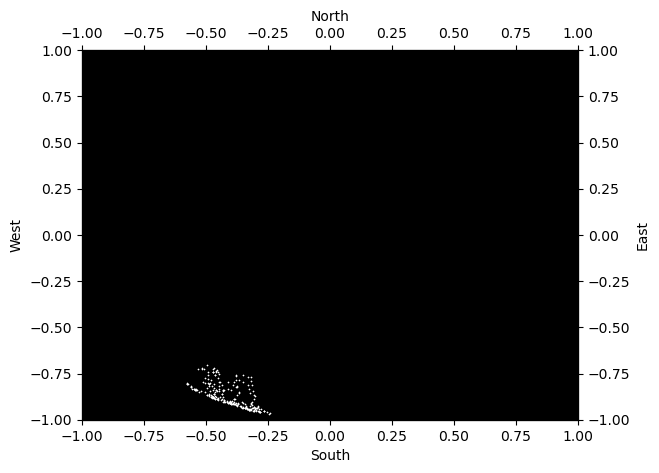

In [3]:
import matplotlib.pyplot as plt
from classes import *
vestel = LocStarMap('New York, New York', datetime.now())
current_df = vestel.construct_table(cleanedstars.loc[cleanedstars['parent_constellation'] == 'Puppis'], am = 8)

vestel.plot_stars(current_df)
#polaris = stars.loc[stars['name'] == 'Polaris']
#plt.scatter(polaris['X'], polaris['Y'], color = 'black', s = 20)

plt.show()

In [16]:
cleanedstars.loc[cleanedstars['parent_constellation'] == 'Puppis']['name'].isna().value_counts()

name
False    204
True      47
Name: count, dtype: int64

In [22]:
cleanedstars.loc[cleanedstars['name'] == 'Mira']

,Unnamed: 0,name,right_ascension,declination,apparent_magnitude,link,parent_constellation
2698,3192,Mira,02h 19m 20.79s,-02° 58′ 37.4″,3.04,/wiki/Mira,Cetus


40.7127281 -74.0060152


(<Figure size 640x480 with 3 Axes>,
 <matplotlib.collections.PathCollection at 0x22b948e1050>)

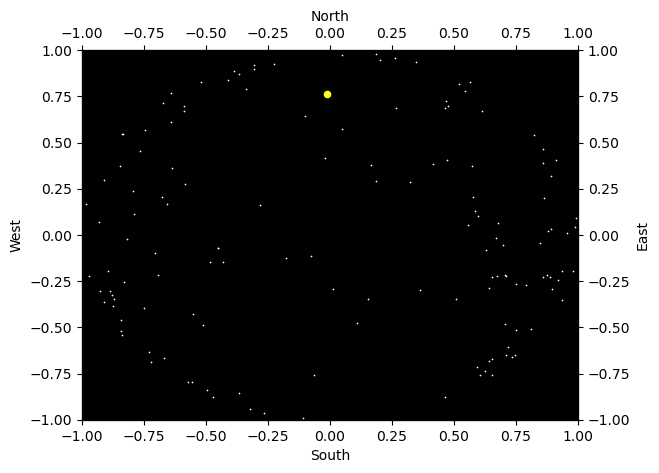

In [4]:
ny = LocStarMap('New York', datetime.now())
nydf = ny.construct_table(cleanedstars, am = 3)

ny.plot_stars(nydf)

In [19]:
nydf2 = nydf.loc[(nydf['X'] != 0) & (nydf['Y'] != 0)].reset_index()
nydf2.loc[nydf2['name'] == 'Polaris']

,index,Unnamed: 0,name,right_ascension,declination,apparent_magnitude,link,parent_constellation,X,Y
135,9128,10898,Polaris,02h 31m 47.08s,+89° 15′ 50.9″,1.97,/wiki/Polaris,Ursa Minor,-0.012688,0.759224


In [10]:
polaris = nydf.loc[nydf['name'] == 'Polaris']
polaris.iloc[0]['name']

'Polaris'

In [88]:
check = []
values = stars['parent_constellation'].value_counts().reset_index().sort_values(by = 'parent_constellation')
for i in values['parent_constellation']:
    print(i)
    check.append(i)

Andromeda
Antlia
Apus
Aquarius
Aquila
Ara
Aries
Auriga
Boötes
Caelum
Camelopardalis
Cancer
Canes Venatici
Canis Major
Canis Minor
Capricornus
Carina
Cassiopeia
Centaurus
Cepheus
Cetus
Chamaeleon
Circinus
Columba
Coma Berenices
Corona Australis
Corona Borealis
Corvus
Crater
Crux
Cygnus
Delphinus
Dorado
Draco
Equuleus
Eridanus
Fornax
Gemini
Grus
Hercules
Horologium
Hydra
Hydrus
Indus
Lacerta
Leo
Leo Minor
Lepus
Libra
Lupus
Lynx
Lyra
Mensa
Microscopium
Monoceros
Musca
Norma
Octans
Ophiuchus
Orion
Pavo
Pegasus
Perseus
Phoenix
Pictor
Pisces
Piscis Austrinus
Puppis
Pyxis
Reticulum
Sagitta
Sagittarius
Scorpius
Sculptor
Scutum
Serpens
Sextans
Taurus
Telescopium
Triangulum
Triangulum Australe
Tucana
Ursa Major
Ursa Minor
Vela
Virgo
Volans
Vulpecula
